# Реализация логистической регрессии в TensorFlow

In [1]:
import numpy as np
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

## Генерируем данные для задачи регрессии

In [3]:
NUM_FEATURES = 2
NUM_SAMPLES = 1000

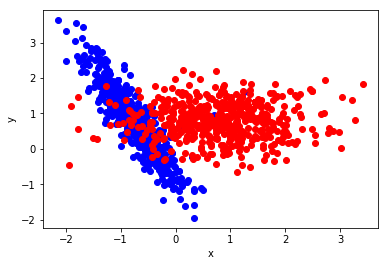

In [4]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = NUM_SAMPLES,
                           n_features = NUM_FEATURES,
                           n_informative = NUM_FEATURES,
                           n_redundant = 0,
                           n_classes = 2,
                           n_clusters_per_class = 1,
                           class_sep = 0.75,
                           random_state = 5432)

y = y.reshape(-1, 1)

ones = np.where(y == 1)   # индексы объектов класса '1'
zeros = np.where(y == 0)  # индексы объектов класса '0'

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or');

## Вспомогательная функция для создания операций

In [5]:
import random
import string

def py_func_with_grad(func, inp, Tout, grad, name = None, stateful = False, graph = None):
    
    name_prefix = ''.join([random.choice(string.ascii_letters) for _ in range(10)])
    
    name = '%s_%s' % (name_prefix, name or '')
    grad_func_name = '%s_grad' % name

    tf.RegisterGradient(grad_func_name)(grad)

    g = graph or tf.get_default_graph()
    with g.gradient_override_map({'PyFunc': grad_func_name, 
                                  'PyFuncStateless': grad_func_name}):
        with tf.name_scope(name, 'PyFuncOp', inp):
            return tf.py_func(func, inp, Tout, stateful = stateful, name = name)

## Реализация линейной опреаций

In [6]:
def linear_op_forward(X, W):
    ''' Реализация линейной операции '''
    return np.dot(X, W.T)  # аргументы являются numpy-массивами

def linear_op_backward(op, grads):
    ''' Реализация вычисления градиента линейной операции '''
    X = op.inputs[0]  # тензор входных данных
    W = op.inputs[1]  # тензор параметров модели
    dX = tf.multiply(grads, W)
    dW = tf.reduce_sum(tf.multiply(X, grads),
                       axis = 0,
                       keep_dims = True)
    return dX, dW

def sigmoid_op_forward(X):
    sigmoid = lambda x: 1. / (1 + np.exp(-x))
    return sigmoid(X)

def sigmoid_op_backward(op, grads):
    y = op.outputs[0]
    y1 = tf.subtract(tf.constant(1.0), y)
    dX = tf.multiply(y, y1)
    return tf.multiply(dX, grads)

## Создание графа вычислений и обучение модели

In [7]:
BATCH_SIZE = NUM_SAMPLES // 10

weights = None  # в этой переменной мы сохраним результат обучения модели
learning_curve = []  # значения ошибки на каждой итерации обучения

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES])
    plh_labels = tf.placeholder(dtype = tf.float32, shape = [None, 1])

    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(shape = [1, NUM_FEATURES],
                                          dtype = tf.float32,
                                          seed = 54321))
    
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(linear_op_forward,         # функция предсказания модели 
                                 [plh_X, var_W],            # аргументы функции
                                 [tf.float32],              # тип выходных значений
                                 name = 'linear_op',        # имя операции 
                                 grad = linear_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)        # объект графа вчислений
    
    # создаем переменную для результата операции sigmoid
    var_Sigmoid = py_func_with_grad(sigmoid_op_forward,
                                    [var_Pred],
                                    [tf.float32],
                                    name = 'sigmoid_op',
                                    grad = sigmoid_op_backward,
                                    graph = sess.graph)
    
    # кроссэнтропийная функция потерь для бмнарной классификации
    cost = tf.losses.sigmoid_cross_entropy(plh_labels, var_Sigmoid)
    
    # инициализируем оптимизатор и указываем скорость обучения
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.9).minimize(cost)

    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    indices = np.arange(len(X))  # массив индексов объектов
    
    # выполняем итерации по 10-ти эпохам
    for epoch in range(10):
        
        # вначале каждой эпохи перемешиваем индексы
        np.random.shuffle(indices)
        
        # внутри каждой эпохи данные разбиваются на батчи
        for batch in range(len(X) // BATCH_SIZE):
            
            # выбираем индексы очередного батча
            batch_indices = indices[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]

            # выполняем шаг обучения: вычисляем ошибку и обновляем веса
            loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                               feed_dict = {plh_X: X[batch_indices],  # передаем входные данные для вычисления
                                            plh_labels: y[batch_indices]})
        
            # сохраняем занчения ошибки для построения кривой обучения
            learning_curve.append(loss)
            
            # выводим текущее значение ошибки для каждого 10го шага
            steps = len(learning_curve) - 1
            if steps % 10 == 0:
                print('[%03d] loss=%.3f weights=%s' % (steps, loss, var_W.eval()))
    
    # сохраняем обученные веса
    weights = var_W.eval()

[000] loss=0.805 weights=[[0.34122106 0.23673391]]
[010] loss=0.679 weights=[[-0.4881123   0.01212347]]
[020] loss=0.651 weights=[[-1.0806104  -0.18505211]]
[030] loss=0.592 weights=[[-1.4930668 -0.3026179]]
[040] loss=0.604 weights=[[-1.8062277  -0.39553288]]
[050] loss=0.625 weights=[[-2.0611496 -0.4889032]]
[060] loss=0.588 weights=[[-2.2756586 -0.5669896]]
[070] loss=0.562 weights=[[-2.46932  -0.624031]]
[080] loss=0.572 weights=[[-2.6395056 -0.678086 ]]
[090] loss=0.541 weights=[[-2.791806  -0.7437726]]


## Визуализируем кривую обучения

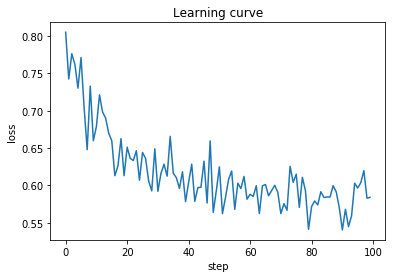

In [8]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve')
plt.plot(learning_curve);

## Визуализируем разделяющую гиперплоскость

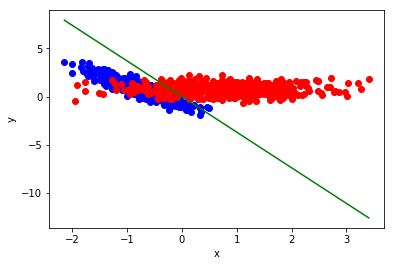

In [9]:
y_pred = - X[:, 0] * weights[0, 0] / weights[0, 1]

order = np.argsort(X[:, 0])

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or',
         X[order, 0], y_pred[order], '-g');